2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 7)

### Imports, Inits, and helper functions

In [1]:
jupyterNotebookEnabled = True
plotting = True
coursework, part = 4, 7
saving = True

if jupyterNotebookEnabled:
    #%load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

In [2]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [3]:
from collections import OrderedDict
from __future__ import division
import skopt
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer
    #trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts

from mylibs.dropout_helper import constructProbs

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
import pickle
from skopt.plots import plot_convergence
from mylibs.jupyter_notebook_helper import DynStats
import operator
from skopt.space.space import Integer, Categorical
from skopt import gp_minimize
from rnn.rnn_batch_norm import RNNBatchNorm

In [4]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

In [5]:
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [6]:
figcount = 0

In [7]:
tensorboardLogdir = 'tf_cw%d_%d' % (coursework, part)

In [8]:
curDtype = tf.float32

In [9]:
reluBias = 0.1

In [10]:
batch_size = 50

num_steps = 6 # number of truncated backprop steps ('n' in the discussion above)
#num_classes = 2
state_size = 10      #each state is represented with a certain width, a vector
learningRate = 1e-4 #default of Adam is 1e-3
#momentum = 0.5
#lamda2 = 1e-2

In [11]:
best_params_filename = 'best_params_rnn.npy'

here the state size is equal to the number of classes because we have given to the last output all the responsibility.

We are going to follow a repetitive process. For example if num_steps=6 then we break the 120 segments into 20 parts

The output of each part will be the genre. We are comparing against the genre every little part 

### MSD 10 genre task

In [12]:
segmentCount = 120
segmentLen = 25

In [13]:
from rnn.msd10_data_providers import MSD10Genre_120_rnn_DataProvider

### Experiment with Best Parameters

In [14]:
best_params = np.load(best_params_filename)
best_params

array([341,   4])

In [15]:
(state_size, num_steps) = best_params
(state_size, num_steps)

(341, 4)

In [16]:
rnnModel = RNNBatchNorm(batch_size=batch_size, rng=rng, dtype = curDtype, config=config,
                      segment_count=segmentCount, segment_len= segmentLen)

In [17]:
show_graph(rnnModel.getGraph(num_steps=num_steps, state_size=state_size))

epochs: 100
rnn steps: 4
state size: 341
End epoch 01 (139.139 secs): err(train)=1.52, acc(train)=0.47, err(valid)=1.86, acc(valid)=0.33, 
End epoch 02 (136.111 secs): err(train)=1.47, acc(train)=0.49, err(valid)=1.74, acc(valid)=0.39, 
End epoch 03 (136.024 secs): err(train)=1.44, acc(train)=0.50, err(valid)=1.76, acc(valid)=0.39, 
End epoch 04 (135.718 secs): err(train)=1.42, acc(train)=0.51, err(valid)=1.71, acc(valid)=0.40, 
End epoch 05 (136.560 secs): err(train)=1.39, acc(train)=0.51, err(valid)=1.59, acc(valid)=0.44, 
End epoch 06 (134.916 secs): err(train)=1.36, acc(train)=0.53, err(valid)=1.61, acc(valid)=0.43, 
End epoch 07 (134.824 secs): err(train)=1.33, acc(train)=0.54, err(valid)=1.62, acc(valid)=0.44, 
End epoch 08 (134.745 secs): err(train)=1.31, acc(train)=0.54, err(valid)=1.53, acc(valid)=0.46, 
End epoch 09 (134.994 secs): err(train)=1.30, acc(train)=0.55, err(valid)=1.51, acc(valid)=0.46, 
End epoch 10 (135.173 secs): err(train)=1.28, acc(train)=0.55, err(valid)=1.4

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:74: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:78: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(False)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:87: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_2.hold(True)
/home/studenthp/pligor.george@gma

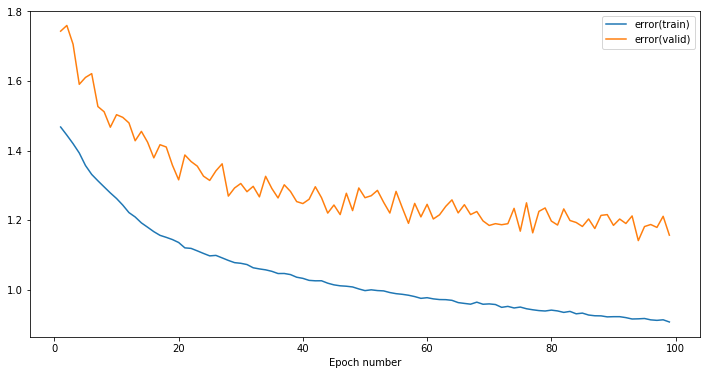

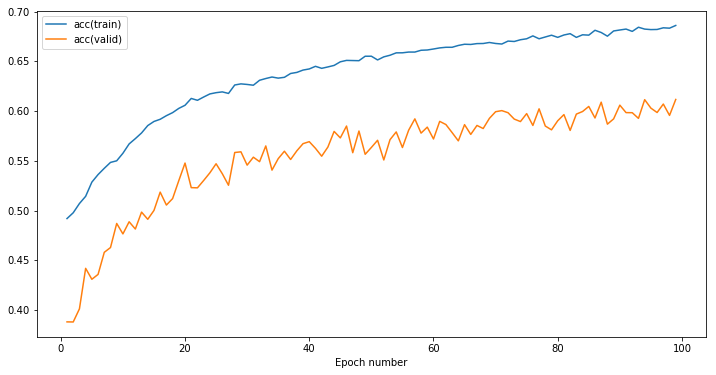

0.611699981689
CPU times: user 4h 52min 58s, sys: 21min 26s, total: 5h 14min 24s
Wall time: 4h 5min 36s


In [19]:
%%time

epochs = 100

stats, keys = rnnModel.run_rnn(state_size = state_size, num_steps=num_steps,
                               epochs = epochs)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()
    if saving:
        figcount += 1
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))

print max(stats[:, -1]) #maximum validation accuracy